In [1]:
from src.core import load_data, show_imgs, perform_nms, calc_mAP
from functools import partial
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms.v2 as v2
from torchvision import models

from fastai.vision.all import DataLoaders, Learner, Metric, OptimWrapper, AvgMetric

In [2]:
df, id2label, id2img = load_data('tmp/train.json', 'data/train')

In [3]:
class RCNNDataset(Dataset):
    def __init__(self, roi_file, img_folder, id2img, crop_size=(224,224), augs=None):
        self.df = pd.read_json(roi_file)
        self.id2img = id2img
        self.tfms = v2.Compose([
            v2.Resize(size=crop_size, antialias=True),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        if augs:
            self.tfms = v2.Compose(self.tfms.transforms[:-1]+augs+self.tfms.transforms[-1])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        roi, roi_id, offset, img_id = self.df.iloc[idx]
        img = read_image(self.id2img[img_id], mode=ImageReadMode.RGB)
        img_id, roi_id = torch.tensor(img_id, dtype=torch.long), torch.tensor(roi_id, dtype=torch.long)
        roi, offset = torch.tensor(roi), torch.tensor(offset)
        x, y, w, h = roi.int()
        crop = img[:, y:y+h, x:x+w]
        return self.tfms(crop), img_id, roi, roi_id, offset

In [4]:
train_ds = RCNNDataset('tmp/train_rois.json', 'data/train', id2img)
valid_ds = RCNNDataset('tmp/valid_rois.json', 'data/train', id2img)

In [5]:
def get_uniform_sampler(roi_ids, num_samples):
    counts = roi_ids.value_counts()
    sample_wts = 1./counts[roi_ids].values
    return WeightedRandomSampler(sample_wts, num_samples)

In [6]:
train_sampler = get_uniform_sampler(train_ds.df.roi_ids, 1280)
train_dl = DataLoader(train_ds, batch_size=32, sampler=train_sampler, pin_memory=True)
valid_sampler = get_uniform_sampler(valid_ds.df.roi_ids, 640)
valid_dl = DataLoader(valid_ds, batch_size=32, sampler=valid_sampler, pin_memory=True)

dls = DataLoaders(train_dl, valid_dl)
dls.n_inp = 1

In [7]:
def get_dls(roi_folder, img_folder, id2img, crop_size=(224,224), train_sampler=None, augs=None, bs=64):
    train_roi_file = f"{roi_folder}/train_rois.json"
    train_ds = RCNNDataset(train_roi_file, img_folder, id2img, crop_size, augs)
    valid_roi_file = f"{roi_folder}/valid_rois.json"
    valid_ds = RCNNDataset(valid_roi_file, img_folder, id2img, crop_size)

    if train_sampler:
        train_dl = DataLoader(train_ds, batch_size=bs, sampler=train_sampler, pin_memory=True)
    else:
        train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, pin_memory=True)
    valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, pin_memory=True)
    
    dls = DataLoaders(train_dl, valid_dl)
    dls.n_inp = 1
    return dls

In [8]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

vgg16.classifier[0].in_features

25088

In [9]:
class RCNNModel(nn.Module):
    def __init__(self, n_classes):
        super(RCNNModel, self).__init__()
        vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        self.vgg16 = vgg16.features
        self.adaptivepool = nn.Sequential(vgg16.avgpool, nn.Flatten())
        self.encoder = nn.Sequential(
            nn.Linear(25088, 4096, bias=False),
            nn.BatchNorm1d(4096), nn.ReLU(),
            nn.Linear(4096, 512, bias=False),
            nn.BatchNorm1d(512), nn.ReLU(),
        )
        self.cls_head = nn.Linear(512, n_classes+1)
        self.reg_head = nn.Linear(512, n_classes*4)

    def forward(self, crops):
        features = self.vgg16(crops)
        features = self.adaptivepool(features)
        encoded = self.encoder(features)
        probs = self.cls_head(encoded)
        pred_offsets = self.reg_head(encoded)
        return probs, pred_offsets

In [10]:
def reg_loss(preds, *targs):
    _, pred_offsets = preds
    _, _, roi_ids, offsets = targs
    if not torch.any(roi_ids!=0):
        return torch.tensor(0.0, device=roi_ids.device, requires_grad=True)
    roi_ids, offsets, pred_offsets = [
        t[roi_ids!=0] for t in [roi_ids, offsets, pred_offsets]
    ]
    bs = pred_offsets.size(0)
    pred_offsets = pred_offsets.view(bs,-1,4)[torch.arange(bs), roi_ids-1]
    return nn.SmoothL1Loss()(pred_offsets, offsets)

def cls_loss(preds, *targs):
    return nn.CrossEntropyLoss()(preds[0], targs[2])

def detn_loss(preds, *targs, beta=1):
    return cls_loss(preds, *targs) + beta*reg_loss(preds, *targs)

In [11]:
model = RCNNModel(len(id2label))

In [12]:
for i, batch in enumerate(dls.train):
    preds = model(batch[0])
    print(cls_loss(preds, *batch[1:]))
    print(reg_loss(preds, *batch[1:]))
    print(detn_loss(preds, *batch[1:]))
    if i==2:  break
    print('\n')

tensor(3.1007, grad_fn=<NllLossBackward0>)
tensor(0.1249, grad_fn=<SmoothL1LossBackward0>)
tensor(3.2257, grad_fn=<AddBackward0>)


tensor(3.1715, grad_fn=<NllLossBackward0>)
tensor(0.0911, grad_fn=<SmoothL1LossBackward0>)
tensor(3.2626, grad_fn=<AddBackward0>)


tensor(3.1607, grad_fn=<NllLossBackward0>)
tensor(0.0982, grad_fn=<SmoothL1LossBackward0>)
tensor(3.2589, grad_fn=<AddBackward0>)


In [12]:
def apply_offsets(rois, pred_offsets):
    # Convert ROIs to center coordinates
    centers = rois[:, :2] + rois[:, 2:]/2
    widths = rois[:, 2]
    heights = rois[:, 3]
    
    # Unpack offsets
    dx = pred_offsets[:, 0]
    dy = pred_offsets[:, 1]
    dw = pred_offsets[:, 2]
    dh = pred_offsets[:, 3]
    
    # Apply transformations
    refined_centers_x = centers[:, 0] + dx * widths
    refined_centers_y = centers[:, 1] + dy * heights
    refined_widths = widths * torch.exp(dw)
    refined_heights = heights * torch.exp(dh)
    
    # Convert back to [x, y, w, h] format
    refined_boxes = torch.stack([
        refined_centers_x - refined_widths/2,
        refined_centers_y - refined_heights/2,
        refined_widths,
        refined_heights
    ], dim=1)
    
    return refined_boxes

In [13]:
def get_preds(img_ids, rois, probs, pred_offsets):
    probs = nn.Softmax(dim=1)(probs)
    scores, pred_ids = probs.max(dim=1)
    # filter background
    img_ids, rois, scores, pred_ids, pred_offsets = [
        t[pred_ids!=0] for t in [img_ids, rois, scores, pred_ids, pred_offsets]
    ]
    # get predicted bbs
    bs = pred_offsets.size(0)
    pred_offsets = pred_offsets.view(bs,-1,4)[torch.arange(bs), pred_ids-1]
    pred_bbs = apply_offsets(rois, pred_offsets)

    return img_ids, pred_ids, pred_bbs, scores

In [14]:
class mAPMetric(Metric):
    def __init__(self, gt_path, pred_path, nms_thresh=0.5):
        self.gt_path, self.pred_path = gt_path, pred_path
        self.nms_thresh, self.df_list = nms_thresh, []
        
    def reset(self):
        self.df_list = []

    def accumulate(self, learn):
        probs, pred_offsets = learn.pred
        img_ids, rois, _, _  = learn.y
        img_ids, pred_ids, pred_bbs, scores = \
        get_preds(img_ids, rois, probs, pred_offsets)
        batch_df = pd.DataFrame({
            'image_id': img_ids.cpu().tolist(),
            'category_id': pred_ids.cpu().tolist(),
            'bbox': pred_bbs.cpu().tolist(),
            'score': scores.cpu().tolist()
        })
        self.df_list.append(batch_df)
            
    @property
    def value(self):
        pred_df = pd.concat(self.df_list, ignore_index=True)
        pred_df = (
            pred_df
            .groupby('image_id').agg(list).reset_index()
            .apply(perform_nms, axis=1, thresh=self.nms_thresh)
            .explode(pred_df.columns.drop('image_id').tolist())
            .dropna(how='any')
        )
        pred_df.to_json(self.pred_path, orient='records')
        return calc_mAP(self.gt_path, self.pred_path)

In [15]:
opt_func = partial(OptimWrapper, opt=torch.optim.Adam)
mAP_metric = mAPMetric('tmp/valid.json', 'tmp/valid_preds.json')
reg_metric, cls_metric = AvgMetric(reg_loss), AvgMetric(cls_loss)
metrics = [mAP_metric, reg_metric, cls_metric]
loss_func = partial(detn_loss, beta=10)

In [16]:
def rcnn_splitter(model):
    body = list(model.vgg16.parameters()) + list(model.adaptivepool.parameters())
    heads = list(model.encoder.parameters()) + \
            list(model.cls_head.parameters()) + \
            list(model.reg_head.parameters())
    return body, heads

learn = Learner(dls, model, loss_func=loss_func, opt_func=opt_func,
                metrics=metrics, splitter=rcnn_splitter)

In [17]:
learn.fine_tune(epochs=1, base_lr=1e-4)

epoch,train_loss,valid_loss,m_ap,reg_loss,cls_loss,time
0,3.059774,2.659087,0.001278,0.118336,1.475727,05:07


epoch,train_loss,valid_loss,m_ap,reg_loss,cls_loss,time
0,2.047300,1.853097,0.005463,0.055510,1.297999,10:39


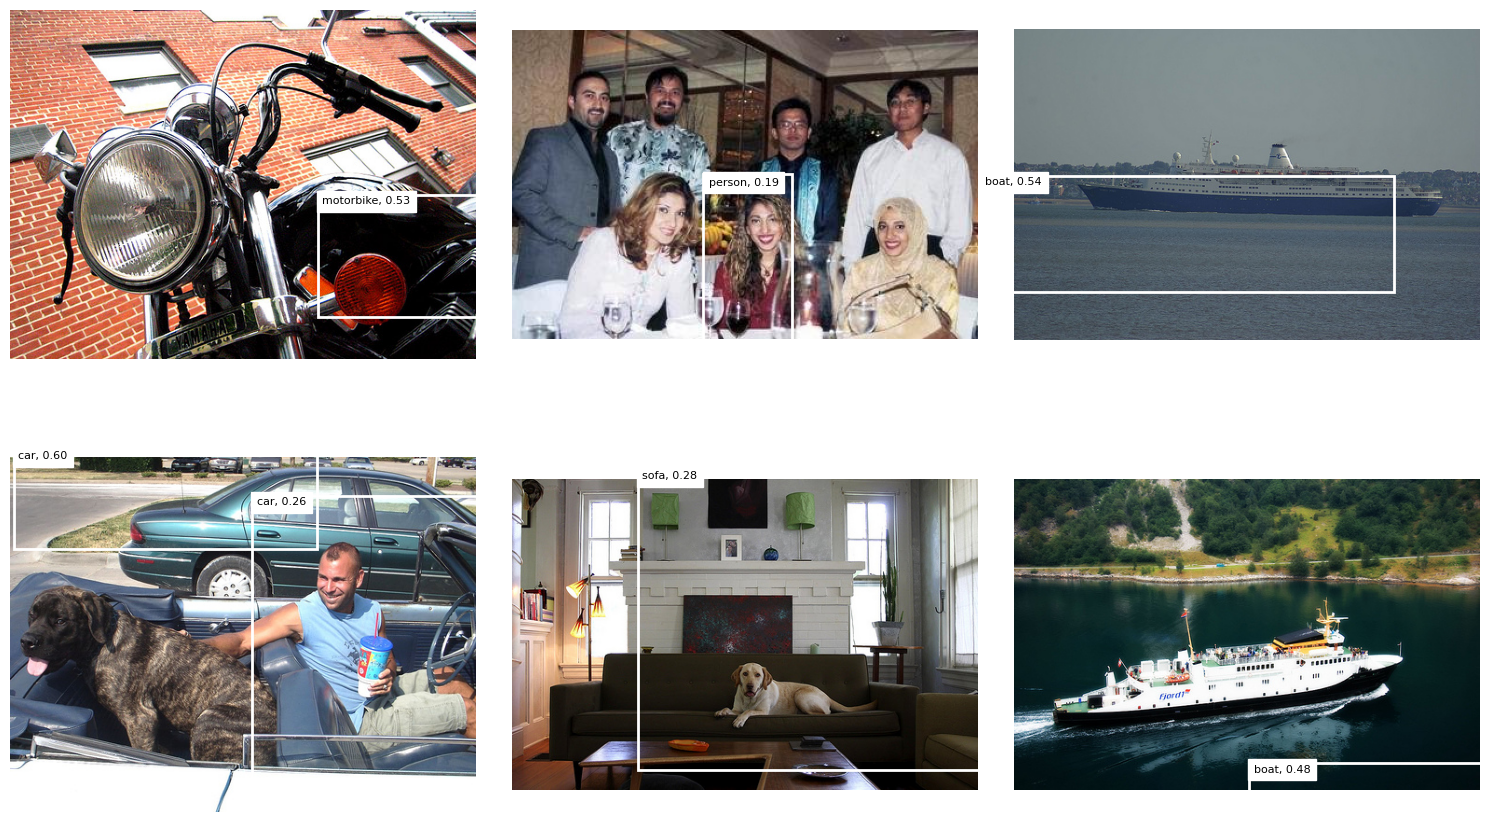

In [20]:
show_imgs('tmp/valid_preds.json', 2, id2label, id2img)